In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input
from tensorflow.keras import regularizers
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lingf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = Loader.load_train()

In [3]:
descriptions = [col for col in train.columns if "description" in col]

print(descriptions)

def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
#train[descriptions].apply(lambda col: col.apply(lambda x: type(x).__name__).value_counts())

#descriptions.append("idx")
#descriptions.append("price")
#descriptions.append("km")

['motor_description', 'transmission_description', 'parking_sensors_description', 'Exterior_Llantas_description', 'Exterior_Molduras_description', 'Exterior_Neumáticos_description', 'Exterior_Puerta_description', 'Exterior_Retrovisor_description', 'Confort_Volante_description', 'seat_description', 'head_supporter_description']


In [4]:
filtered_columns = ["idx", "price", "km", "fuelType", "full_description"]
train = train[filtered_columns]
train["price_per_kilometer"] = train["price"]/train["km"]
train.dropna(inplace=True)
train

,idx,price,km,fuelType,full_description,price_per_kilometer
0,105953,22490,68887.0,Gasolina,"Motor de 1,3 litros ( 1.332 cc ) , cuatro cili...",0.326477
1,15683,19990,116892.0,Diésel,"Motor de 2,0 litros ( 1.969 cc ) , cuatro cili...",0.171013
2,153684,17500,130820.0,Diésel,"Motor de 1,6 litros ( 1.560 cc ) , cuatro cili...",0.133772
3,156928,22900,50773.0,Híbrido,"Motor de 1,8 litros ( 1.798 cc ) , cuatro cili...",0.451027
4,24443,4000,269000.0,Diésel,"Motor de 1,9 litros ( 1.910 cc ) , 4 cilindros...",0.014870
...,...,...,...,...,...,...
115592,19845,22900,77653.0,Diésel,"Motor de 1,6 litros ( 1.598 cc ) , cuatro cili...",0.294902
115593,102652,4995,157000.0,Gasolina,"Motor de 2,0 litros ( 1.997 cc ) , 4 cilindros...",0.031815
115594,101658,17490,129000.0,Gas natural (CNG),"Motor de 1,4 litros ( 1.395 cc ) , cuatro cili...",0.135581
115595,69350,19850,151560.0,Diésel,"Motor de 2,2 litros ( 2.191 cc ) , cuatro cili...",0.130971


In [5]:
#Parameters
verb_size = 200

In [6]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales (pero mantener los números)
    text = text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)  # Eliminar signos de puntuación, pero mantener números
    tokens = text.split()
    
    # Filtrar tokens, eliminando las stopwords
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    
    return filtered_tokens

train['tokens'] = train['full_description'].apply(preprocess_text)
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=verb_size, window=1, min_count=3, workers=8)
word_vectors = model_w2v.wv

def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 
train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, word_vectors))

In [7]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['fuelType'])
train_df.head()

,idx,price,km,fuelType,full_description,price_per_kilometer,tokens,embedding
2242,92306,13900,32306.0,Híbrido,"Motor de 1,0 litros ( 999 cc ) , tres cilindro...",0.430261,"[motor, 10, litros, 999, cc, tres, cilindros, ...","[-0.10965032, -0.02863734, -0.33314055, 0.2118..."
27893,87882,5250,209000.0,Diésel,"Motor de 2 litros ( 1.991 cc ) , 4 cilindros e...",0.025120,"[motor, 2, litros, 1991, cc, 4, cilindros, lín...","[-0.1899388, -0.019999104, -0.43883243, 0.2709..."
87329,83668,32890,15077.0,Híbrido enchufable,"Motor de 2,5 litros ( 2.488 cc ) , cuatro cili...",2.181468,"[motor, 25, litros, 2488, cc, cuatro, cilindro...","[-0.12516, 0.015139673, -0.26672253, 0.3346757..."
37341,79319,34900,76225.0,Diésel,"Motor de 2,0 litros ( 1.995 cc ) , cuatro cili...",0.457855,"[motor, 20, litros, 1995, cc, cuatro, cilindro...","[-0.01226154, -0.018809684, -0.25967723, 0.239..."
83683,89910,18960,80671.0,Híbrido enchufable,"Motor de 1,6 litros ( 1.580 cc ) , cuatro cili...",0.235029,"[motor, 16, litros, 1580, cc, cuatro, cilindro...","[-0.12776579, 0.034661345, -0.33779395, 0.2565..."


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_shape=[verb_size],
                          kernel_regularizer=regularizers.l2(0.001)
                          ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64 , activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)
                          ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)
                          ),
    tf.keras.layers.Dense(units=1, activation='softplus')
    ])#output

def custom_loss(y_true, y_pred):
    # Penalizar mas los valores negativos
    loss = tf.where(y_pred < 0, tf.square(y_pred - y_true) * 10, tf.square(y_pred - y_true))
    return tf.reduce_mean(loss)

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.01),
    loss = custom_loss
)

c:\Users\lingf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
x = np.stack(train_df["embedding"].values)
y = train_df['price'].to_numpy()

scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(x)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [13]:
print("COMIENZA EL ENTRENAMIENTO...")
historial = model.fit(x_scaled, y_scaled, epochs=30, batch_size = 8, verbose=True)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 5s 703us/step - loss: 0.8154
Epoch 2/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 682us/step - loss: 0.6343
Epoch 3/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 665us/step - loss: 0.6036
Epoch 4/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 672us/step - loss: 0.6718
Epoch 5/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 676us/step - loss: 0.5957
Epoch 6/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 676us/step - loss: 0.7120
Epoch 7/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 671us/step - loss: 0.5941
Epoch 8/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - loss: 0.6198
Epoch 9/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 679us/step - loss: 0.6218
Epoch 10/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 678us/step - loss: 0.5775
Epoch 11/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 701us/step - loss: 0.5787
Epoch 12/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 711us/step - loss: 0.5765
Epoch 13/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4s 681us/step - loss: 0.6117
Epoch 14/30
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 4

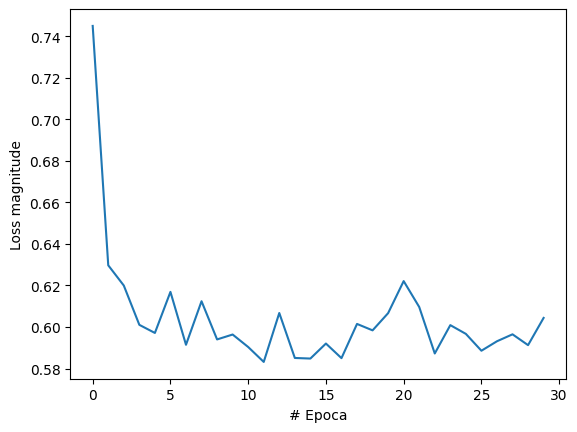

In [14]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(historial.history["loss"])

In [26]:
prediction = scaler_y.inverse_transform(model.predict(np.stack(test_df["embedding"].values))).flatten()
realPrice = test_df['price'].to_numpy()

690/690 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


In [27]:
result = pd.DataFrame({'Prediction': prediction, 'Real price': realPrice})

diff = np.mean(abs( (realPrice - prediction)/realPrice ))
print(result)
print("Hay un MAPE de " + str(diff) + "%")
plt.show()

         Prediction  Real price
0      23664.306641       46900
1      23619.218750       29999
2      23601.490234       20795
3      23645.542969       24460
4      23613.185547       21900
...             ...         ...
22074  23590.474609       14462
22075  23603.250000       26490
22076  23614.136719       22900
22077  23682.710938       47900
22078  23661.158203       42920

[22079 rows x 2 columns]
Hay un MAPE de 0.8228959838018425%
